# Load Data
The primary data source is the spreadsheet data file from the presentation organization portal. It is also possible to load the data after it has been separated into oral and poster dataframes.

The abstracts were initially collected for session organization and not for public publication. This Jupyter notebook displays the steps used to create embeddings from the presentation titles and abstracts. However, since the orginal data is not available for inclusion in this repository, this notebook also enables loading the presentation data without the abstracts. This includes the presentation data and the embeddings created from those abstracts. Loading the embeddings also enables much quicker processing and data exploration as the embeddings take many minutes to calculate.

## Primary Data Source

In [1]:
import pandas as pd

df = pd.read_excel("2024 List.xlsx")
df['Title and Abstract'] = df['Submission-Call for Abstracts-Presentation Title-Character max 160'] + ': ' +df['Submission-Call for Abstracts-Abstract-Character max 4000-Abstracts will only be used to evaluate quality of talk and topic. They will not be published or able to be edited later.']
print(f"Title and Abstract: \n{df['Title and Abstract'].head()}")
df = df.rename(columns={'Submission-Call for Abstracts-Session':'Original Session',
                        'Submission-Call for Abstracts-Presentation Title-Character max 160':'Title',
                        'Submission-Call for Abstracts-Abstract-Character max 4000-Abstracts will only be used to evaluate quality of talk and topic. They will not be published or able to be edited later.':'Abstract',
                        'Submission-Call for Abstracts-Submission ID - 7 digits':'Abstract ID',
                        'Submission-Call for Abstracts-Technical Community':'Original Technical Community',
                        'Owner-First Name':'First Name',
                        'Owner-Last Name':'Last Name',
                        })
# Seperate Poster and Oral presentaitons
poster_df = df[df['Original Session'].str.contains('POSTER', case=False, na=False)].copy()
oral_df = df[~df['Original Session'].str.contains('POSTER', case=False, na=False)].copy()
oral_topics = oral_df['Title and Abstract'].tolist()

Title and Abstract: 
0    Challenges and Opportunities for Adopting Past...
1    Evaluation of Climate Adaptation Strategies fo...
2    Measuring and modeling the impact of tire wear...
3    Application of multispectral and thermal UAV-b...
4    Implementing Image-Based Phenotyping in Lab-Sc...
Name: Title and Abstract, dtype: object


In 2024, one oral presentation (Abstract ID of 2401361) is alone in its session (Session 301) as it was included in a hybrid session. This presentation was removed from processing and overall statistics since it did not have any other presentations with which it could be similar.

In [2]:
oral_df_sim = oral_df[oral_df['Abstract ID'] != 2401361]

### Save dataframes for accessing without the spreadsheet.

In [3]:
import pickle
with open('oral_df_doc.pkl', 'wb') as file:
    pickle.dump(oral_df, file)
with open('oral_df_doc_sim.pkl', 'wb') as file:
    pickle.dump(oral_df_sim, file)

## Alternative: Load Processed Dataframes


In [62]:
# For loading base oral dataframe:
import pickle

with open('oral_df_doc.pkl', 'rb') as file:
    oral_df = pickle.load(file)
oral_topics = oral_df['Title and Abstract'].tolist()

In [6]:
# For loading oral dataframe without the isolated presentations:
import pickle
# Load Embeddings
with open('oral_df_doc_sim.pkl', 'rb') as file:
    oral_df_sim = pickle.load(file)

## Create dataframes for publishing

### Create dataframe with only essential presentation data for publishing

In [4]:
df_presentations = oral_df[['Abstract ID', 'First Name', 'Last Name', 'Title', 'Abstract', 'Original Technical Community','Original Session']].copy()
df_presentations.to_pickle('df_presentations.pkl')

In [5]:
# Create an abstract free dataframe

import pickle
df_no_abstract = df_presentations.drop(['First Name', 'Last Name', 'Abstract',], axis=1)
with open('df_pres_basic.pkl', 'wb') as file:
    pickle.dump(df_no_abstract, file)

In [ ]:
# For loading abstract free dataframe:
import pickle
# Load Embeddings
with open('df_pres_basic.pkl', 'rb') as file:
    df_no_abstract = pickle.load(file)

### Dataframe Encryption
Create an abstract free dataframe and an encrypted dataframe for publishing.

The file name for the encrypted file and the password should be changed in any future application.

This is a Markdown cell without a password so that it can be committed. Encrypted version was initially set with this code in a python cell.
```
password_df = '' # Set password here.
filename_enc_df = 'encrypted_df_example.crypt'
```

In [11]:
# Create an encrypted dataframe for publishing.
import pandas as pd
import cryptpandas as crp
# Encrypt the DataFrame and save as a pickle
crp.to_encrypted(df_presentations, password=password_df, path=filename_enc_df)


In [12]:
# Decrypting the encrypted dataframe.
import pandas as pd
import cryptpandas as crp
decrypted_df = crp.read_encrypted(path=filename_enc_df, password=password_df)


# Calculate Embeddings and Token Lengths
### Model: all-MiniLM-L6-v2

In [6]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
mini_embeddings_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# Check the model settings and similiarity function with which the model was trained.
print("Model Card:\n", mini_embeddings_model.model_card_data)
print("Similarity Function (None defaults to cosine): ", mini_embeddings_model.similarity_fn_name)
print("Max Sequence Length: ", mini_embeddings_model.max_seq_length)

Model Card:
 tags:
- sentence-transformers
- sentence-similarity
- feature-extraction
base_model: sentence-transformers/all-MiniLM-L6-v2
pipeline_tag: sentence-similarity
library_name: sentence-transformers
Similarity Function (None defaults to cosine):  cosine
Max Sequence Length:  256


### Check Token Lengths

Token indices sequence length is longer than the specified maximum sequence length for this model (454 > 256). Running this sequence through the model will result in indexing errors


Tokenizer maximum sequence length: 256
An example of the tokens within a title and abstract:
utilizing super cap ##ac ##itors to improve battery performance in electric mobile machinery : off - road and heavy machinery drive ##train ##s are elect ##ri ##fying . many of these new electrified machinery designs rely on batteries for energy storage . however , batteries can be heavy , expensive and bulky . therefore , engineers must carefully consider the battery and energy storage systems within electrified drive ##train ##s . in situations with highly variable power demands or even reg ##ener ##ative currents , the ability to deliver or absorb power can be the critical design parameter rather than overall energy density of the battery . in these cases , a super cap ##ac ##itor provides an alternative method of achieving power criteria instead of increasing the battery pack size or switching to otherwise less desirable battery technologies .


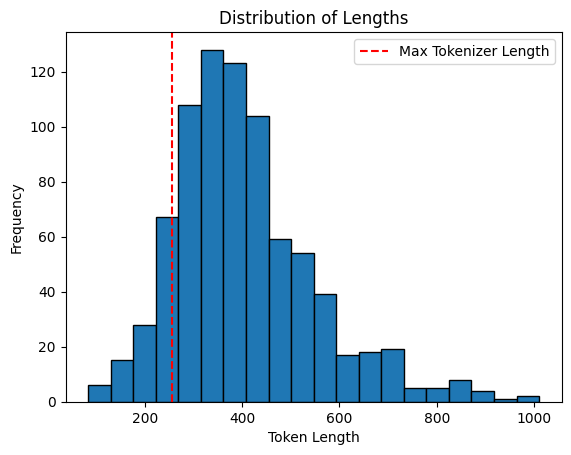

In [7]:
mini_tokenizer = mini_embeddings_model.tokenizer
mini_max_length = mini_tokenizer.model_max_length
print(f"Tokenizer maximum sequence length: {mini_max_length}")
mini_tokenized_lengths = [len(mini_tokenizer.tokenize(text)) for text in oral_topics]
mini_token_out = [mini_tokenizer.tokenize(text, truncation=True, max_length=mini_max_length) for text in oral_topics]
print("An example of the tokens within a title and abstract:")
concatenated_output = [" ".join(tokens) for tokens in mini_token_out]  # List of strings
print(concatenated_output[609])

import matplotlib.pyplot as plt
# Plot length  distribution
plt.hist(mini_tokenized_lengths, bins=20, edgecolor='black')
plt.axvline(x=mini_max_length, color='r',
            linestyle='--', label='Max Tokenizer Length')
plt.title('Distribution of Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Embed presentations and Calculate Similarity

In [8]:
import time
start_time = time.time()
mini_embeddings = mini_embeddings_model.encode(oral_topics)
end_time = time.time()
mini_elapsed_time = end_time - start_time
print(f"Titles Embedded: {len(mini_embeddings)}, Length of Vectors: {len(mini_embeddings[0])}")
print(f"Encoding time: {mini_elapsed_time:.4f} seconds")


Titles Embedded: 810, Length of Vectors: 384
Encoding time: 18.9125 seconds


In [9]:
mini_similarities = mini_embeddings_model.similarity(mini_embeddings, mini_embeddings)

## Model: all-mpnet-base-v2

In [10]:
mpnet_embeddings_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
print("Model Card:\n", mpnet_embeddings_model.model_card_data)
print("Similarity Function (None defaults to cosine): ", mpnet_embeddings_model.similarity_fn_name)
print("Max Sequence Length: ", mpnet_embeddings_model.max_seq_length)

Model Card:
 tags:
- sentence-transformers
- sentence-similarity
- feature-extraction
base_model: sentence-transformers/all-mpnet-base-v2
pipeline_tag: sentence-similarity
library_name: sentence-transformers
Similarity Function (None defaults to cosine):  cosine
Max Sequence Length:  384


### Check Token Lengths

Token indices sequence length is longer than the specified maximum sequence length for this model (454 > 384). Running this sequence through the model will result in indexing errors


Tokenizer maximum sequence length: 384
utilizing super cap ##ac ##itors to improve battery performance in electric mobile machinery : off - road and heavy machinery drive ##train ##s are elect ##ri ##fying . many of these new electrified machinery designs rely on batteries for energy storage . however , batteries can be heavy , expensive and bulky . therefore , engineers must carefully consider the battery and energy storage systems within electrified drive ##train ##s . in situations with highly variable power demands or even reg ##ener ##ative currents , the ability to deliver or absorb power can be the critical design parameter rather than overall energy density of the battery . in these cases , a super cap ##ac ##itor provides an alternative method of achieving power criteria instead of increasing the battery pack size or switching to otherwise less desirable battery technologies .


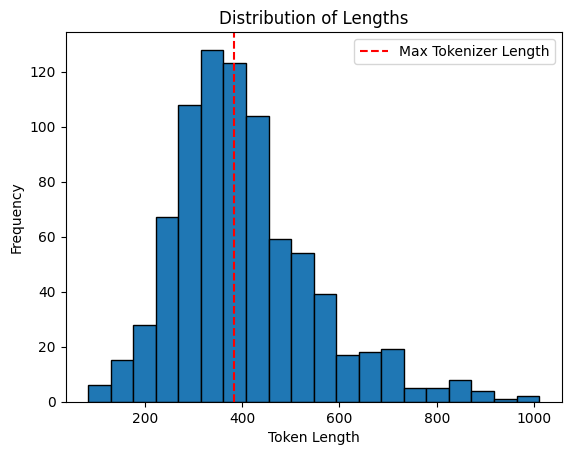

In [11]:
mpnet_tokenizer = mpnet_embeddings_model.tokenizer
mpnet_max_length = mpnet_tokenizer.model_max_length
print(f"Tokenizer maximum sequence length: {mpnet_max_length}")
mpnet_tokenized_lengths = [len(mpnet_tokenizer.tokenize(text)) for text in oral_topics]
mpnet_token_out = [mpnet_tokenizer.tokenize(text, truncation=True, max_length=mpnet_max_length) for text in oral_topics]
concatenated_output = [" ".join(tokens) for tokens in mpnet_token_out]  # List of strings
print(concatenated_output[609])
import matplotlib.pyplot as plt
# Plot length  distribution
plt.hist(mpnet_tokenized_lengths, bins=20, edgecolor='black')
plt.axvline(x=mpnet_max_length, color='r',
            linestyle='--', label='Max Tokenizer Length')
plt.title('Distribution of Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Embed Presentations

In [12]:
import time
start_time = time.time()
mpnet_embeddings = mpnet_embeddings_model.encode(oral_topics)
end_time = time.time()
mpnet_elapsed_time = end_time - start_time
print(f"Titles Embedded: {len(mpnet_embeddings)}, Length of Vectors: {len(mpnet_embeddings[0])}")
print(f"Encoding time: {mpnet_elapsed_time:.4f} seconds")


Titles Embedded: 810, Length of Vectors: 768
Encoding time: 265.4264 seconds


In [13]:
mpnet_similarities = mpnet_embeddings_model.similarity(mpnet_embeddings, mpnet_embeddings)

## Model: cde-small-v1

In [59]:
# Line below should be uncommented to run. It must be commented out for Git commit as its output is interpreted as containing a secret. 
# cde_embeddings_model = SentenceTransformer('jxm/cde-small-v1', trust_remote_code=True)
print("Model Card:\n", cde_embeddings_model.model_card_data)
print("Similarity Function (None defaults to cosine): ", cde_embeddings_model.similarity_fn_name)
print("Max Token Length:", cde_embeddings_model.tokenizer.model_max_length)

Model Card:
 tags:
- sentence-transformers
- sentence-similarity
- feature-extraction
base_model: jxm/cde-small-v1
pipeline_tag: sentence-similarity
library_name: sentence-transformers
Similarity Function (None defaults to cosine):  cosine
Max Token Length: 512


### Check Token Lengths

Token indices sequence length is longer than the specified maximum sequence length for this model (730 > 512). Running this sequence through the model will result in indexing errors


Tokenizer maximum sequence length: 512
utilizing super cap ##ac ##itors to improve battery performance in electric mobile machinery : off - road and heavy machinery drive ##train ##s are elect ##ri ##fying . many of these new electrified machinery designs rely on batteries for energy storage . however , batteries can be heavy , expensive and bulky . therefore , engineers must carefully consider the battery and energy storage systems within electrified drive ##train ##s . in situations with highly variable power demands or even reg ##ener ##ative currents , the ability to deliver or absorb power can be the critical design parameter rather than overall energy density of the battery . in these cases , a super cap ##ac ##itor provides an alternative method of achieving power criteria instead of increasing the battery pack size or switching to otherwise less desirable battery technologies .


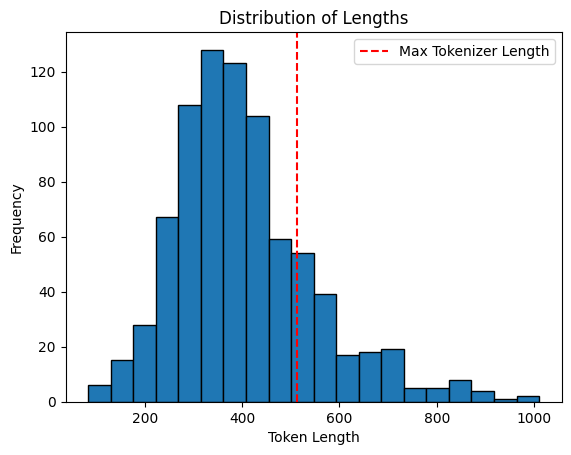

In [15]:
cde_tokenizer = cde_embeddings_model.tokenizer
cde_max_length = cde_tokenizer.model_max_length
print(f"Tokenizer maximum sequence length: {cde_max_length}")
cde_tokenized_lengths = [len(cde_tokenizer.tokenize(text)) for text in oral_topics]
cde_token_out = [cde_tokenizer.tokenize(text, truncation=True, max_length=cde_max_length) for text in oral_topics]
cde_concatenated_output = [" ".join(tokens) for tokens in cde_token_out]  # List of strings
print(cde_concatenated_output[609])

import matplotlib.pyplot as plt
# Plot length  distribution
plt.hist(cde_tokenized_lengths, bins=20, edgecolor='black')
plt.axvline(x=cde_max_length, color='r',
            linestyle='--', label='Max Tokenizer Length')
plt.title('Distribution of Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Embed Presentations
First, create the dataset embeddings as required by this model.

In [16]:
import time
import random

minicorpus_size = cde_embeddings_model[0].config.transductive_corpus_size
minicorpus_docs = random.sample(oral_topics, k=minicorpus_size) # Put some strings here that are representative of your corpus, for example by calling random.sample(corpus, k=minicorpus_size)
assert len(minicorpus_docs) == minicorpus_size # You must use exactly this many documents in the minicorpus. You can oversample if your corpus is smaller.


start_time = time.time()
cde_dataset_embeddings = cde_embeddings_model.encode(
    minicorpus_docs,
    prompt_name="document",
    convert_to_tensor=True
)
end_time = time.time()
cde_dataset_elapsed_time = end_time - start_time
print(f"Titles Embedded: {len(cde_dataset_embeddings)}, Length of Vectors: {len(cde_dataset_embeddings[0])}")
print(f"Dataset Encoding time: {cde_dataset_elapsed_time:.4f} seconds")

Titles Embedded: 512, Length of Vectors: 768
Dataset Encoding time: 200.7328 seconds


Then perform the main embedding

In [17]:
start_time = time.time()
cde_doc_embeddings = cde_embeddings_model.encode(
    oral_topics,
    prompt_name="document",
    dataset_embeddings=cde_dataset_embeddings,
    convert_to_tensor=True,
)
end_time = time.time()
cde_doc_elapsed_time = end_time - start_time
print(f"Titles Embedded: {len(cde_doc_embeddings)}, Length of Vectors: {len(cde_doc_embeddings[0])}")
print(f"Document Encoding time: {cde_doc_elapsed_time:.4f} seconds")
cde_elapsed_time = cde_doc_elapsed_time+cde_dataset_elapsed_time
print(f"Total Encoding time: {(cde_elapsed_time):.4f} seconds")

Titles Embedded: 810, Length of Vectors: 768
Document Encoding time: 723.0562 seconds
Total Encoding time: 923.7890 seconds


In [18]:
cde_similarities = cde_embeddings_model.similarity(cde_doc_embeddings, cde_doc_embeddings)

## Model: nomic-embed-text-v1.5

In [19]:
# Load the model in Sentence Transformers to check statistics
from sentence_transformers import SentenceTransformer

nomic_embeddings_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)
print("Model Card:\n", nomic_embeddings_model.model_card_data)
print("Similarity Function (None defaults to cosine): ", nomic_embeddings_model.similarity_fn_name)
print("Max Token Length:", nomic_embeddings_model.tokenizer.model_max_length)


<All keys matched successfully>


Model Card:
 tags:
- sentence-transformers
- sentence-similarity
- feature-extraction
base_model: nomic-ai/nomic-embed-text-v1.5
pipeline_tag: sentence-similarity
library_name: sentence-transformers
Similarity Function (None defaults to cosine):  cosine
Max Token Length: 8192


### Check Token Lengths

Tokenizer maximum sequence length: 8192
Example Tokenized Title and Abstract:
utilizing super cap ##ac ##itors to improve battery performance in electric mobile machinery : off - road and heavy machinery drive ##train ##s are elect ##ri ##fying . many of these new electrified machinery designs rely on batteries for energy storage . however , batteries can be heavy , expensive and bulky . therefore , engineers must carefully consider the battery and energy storage systems within electrified drive ##train ##s . in situations with highly variable power demands or even reg ##ener ##ative currents , the ability to deliver or absorb power can be the critical design parameter rather than overall energy density of the battery . in these cases , a super cap ##ac ##itor provides an alternative method of achieving power criteria instead of increasing the battery pack size or switching to otherwise less desirable battery technologies .


C:\Users\jdv223\AppData\Local\Temp\ipykernel_26152\608819261.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


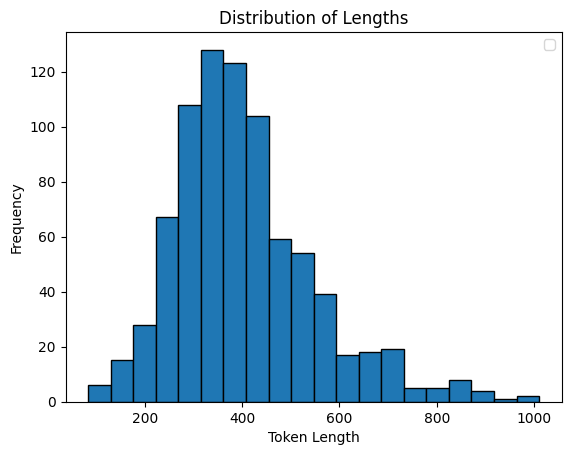

In [20]:
nomic_tokenizer = nomic_embeddings_model.tokenizer
nomic_max_length = nomic_tokenizer.model_max_length
print(f"Tokenizer maximum sequence length: {nomic_max_length}")
nomic_tokenized_lengths = [len(nomic_tokenizer.tokenize(text)) for text in oral_topics]
nomic_token_out = [nomic_tokenizer.tokenize(text, truncation=True, max_length=nomic_max_length) for text in oral_topics]
nomic_concatenated_output = [" ".join(tokens) for tokens in nomic_token_out]  # List of strings
print("Example Tokenized Title and Abstract:")
print(nomic_concatenated_output[609])

import matplotlib.pyplot as plt
# Plot length  distribution
plt.hist(nomic_tokenized_lengths, bins=20, edgecolor='black')
# Do not plot the maximum level as it is way beyond the token length range.
# plt.axvline(x=nomic_max_length, color='r',
#             linestyle='--', label='Max Tokenizer Length')
plt.title('Distribution of Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Embed Presentations
For this model, a separate library is specifically provided that promises better performance than Sentence Transformers so it is used instead.

In [21]:
import time
from nomic import embed
start_time = time.time()

output = embed.text(
    texts=oral_topics,
    model='nomic-embed-text-v1.5',
    task_type='clustering',
    inference_mode='local',
)
nomic_embeddings = output['embeddings']
end_time = time.time()
nomic_elapsed_time = end_time - start_time
print(f"Titles Embedded: {len(nomic_embeddings)}, Length of Vectors: {len(nomic_embeddings[0])}")
print(f"Encoding time: {nomic_elapsed_time:.4f} seconds")

Titles Embedded: 810, Length of Vectors: 768
Encoding time: 1325.0196 seconds


In [22]:
nomic_similarities = nomic_embeddings_model.similarity(nomic_embeddings, nomic_embeddings)

### Convert Similarities to Dataframes

In [23]:
df_similarity_mini = pd.DataFrame(mini_similarities, index = oral_df.index, columns=oral_df.index)
df_similarity_mpnet = pd.DataFrame(mpnet_similarities, index = oral_df.index, columns=oral_df.index)
df_similarity_cde = pd.DataFrame(cde_similarities, index = oral_df.index, columns=oral_df.index)
df_similarity_nomic = pd.DataFrame(nomic_similarities, index = oral_df.index, columns=oral_df.index)

## Save Embeddings and Similarities

In [24]:
import torch
import pickle
# Save the embeddings to files
with open('oral mini embeddings.pkl', 'wb') as file:
    pickle.dump(mini_embeddings, file)
with open('oral mpnet embeddings.pkl', 'wb') as file:
    pickle.dump(mpnet_embeddings, file)
with open('oral cde embeddings.pkl', 'wb') as file:
    pickle.dump(cde_doc_embeddings, file)
with open('oral nomic embeddings.pkl', 'wb') as file:
    pickle.dump(nomic_embeddings, file)
# Save the similarities
torch.save(mini_similarities, 'oral mini similarities.pt')
torch.save(mpnet_similarities, 'oral mpnet similarities.pt')
torch.save(cde_similarities, 'oral cde similarities.pt')
torch.save(nomic_similarities, 'oral nomic similarities.pt')

In [25]:
# Save the embedding dataframes
df_similarity_mini.to_pickle('miniLM_similarities_oral.pkl')
df_similarity_mpnet.to_pickle('mpnet_similarities_oral.pkl') 
df_similarity_cde.to_pickle('cde_similarities_oral.pkl')
df_similarity_nomic.to_pickle('nomic_similarities_oral.pkl')

## Load Embeddings and Similarities

Load the Embeddings

In [10]:
import torch
import pickle
import numpy as np
import pandas as pd

# Load the embeddings from files
with open('oral mini embeddings.pkl', 'rb') as file:
    mini_embeddings = pickle.load(file)
with open('oral mpnet embeddings.pkl', 'rb') as file:
    mpnet_embeddings = pickle.load(file)
with open('oral cde embeddings.pkl', 'rb') as file:
    cde_doc_embeddings = pickle.load(file)
with open('oral nomic embeddings.pkl', 'rb') as file:
    nomic_embeddings = pickle.load(file)

##### Load the Similarity Tensors

In [20]:
mini_similarities = torch.load('oral mini similarities.pt', weights_only=False)
mpnet_similarities = torch.load('oral mpnet similarities.pt', weights_only=False)
cde_similarities = torch.load('oral cde similarities.pt', weights_only=False)
nomic_similarities = torch.load('oral nomic similarities.pt', weights_only=False)

##### Load the Similarity Dataframes

In [37]:
df_similarity_mini = pd.read_pickle("miniLM_similarities_oral.pkl")
df_similarity_mpnet = pd.read_pickle('mpnet_similarities_oral.pkl') 
df_similarity_cde = pd.read_pickle('cde_similarities_oral.pkl')
df_similarity_nomic = pd.read_pickle('nomic_similarities_oral.pkl')

# Process Similarity
Process similarity by session and for each presentation within a session.
**This is part is done within the presentation app.**
Following the steps below allow processing outside of the app.

In [26]:
def calculate_cluster_similarities(similarity_matrix, labels):
    """
    Calculate average similarity of each document with others in its cluster
    
    Returns:
    - document_similarities: Average similarity of each document with its cluster
    - cluster_avg_similarities: Average similarity for each cluster
    """
    n_samples = len(labels)
    document_similarities = np.zeros(n_samples)
    cluster_avg_similarities = {}
    
    for i in range(n_samples):
        # Get indices of other documents in the same cluster
        cluster_idx = np.where(labels == labels[i])[0]
        cluster_idx = cluster_idx[cluster_idx != i]  # Exclude self
        
        if len(cluster_idx) > 0:  # If there are other documents in the cluster
            # Calculate average similarity with other documents in cluster
            document_similarities[i] = np.mean(similarity_matrix[i, cluster_idx])
        
    # Calculate average similarity for each cluster
    unique_clusters = np.unique(labels)
    for cluster in unique_clusters:
        cluster_mask = labels == cluster
        cluster_docs = np.where(cluster_mask)[0]
        
        if len(cluster_docs) > 1:
            cluster_similarities = []
            for doc in cluster_docs:
                other_docs = cluster_docs[cluster_docs != doc]
                avg_sim = np.mean(similarity_matrix[doc, other_docs])
                cluster_similarities.append(avg_sim)
            cluster_avg_similarities[cluster] = np.mean(cluster_similarities)
        else:
            cluster_avg_similarities[cluster] = 0.0
            
    return document_similarities, cluster_avg_similarities

### Select similarity dataframe of your choice

In [27]:
df_similarity = df_similarity_nomic

### Calculate the Session and Presentation Similarity Statistics

In [28]:
pres_session_similarity, session_similarity = calculate_cluster_similarities(df_similarity.to_numpy(), np.array(df_presentations['Original Session']))
df_presentations['Presentation-Session Similarity'] = pres_session_similarity
df_presentations['Session Similarity'] = df_presentations['Original Session'].map(session_similarity)

# Calculate standard deviation for each 'Original Session'
df_presentations['Session Std Dev'] = df_presentations.groupby('Original Session')['Presentation-Session Similarity'].transform('std')
# Calculate deviation from the mean
df_presentations['Raw Deviation'] = df_presentations['Presentation-Session Similarity'] - df_presentations['Session Similarity']
# Calculate standardized deviation
df_presentations['Standardized Deviation'] = df_presentations['Raw Deviation'] / df_presentations['Session Std Dev']

# Create the Sessions DataFrame
df_sessions = df_presentations[['Original Session', 'Session Similarity', 'Session Std Dev']].copy()
# Drop duplicate rows, keeping only the first instance, then reindex.
df_sessions.drop_duplicates(subset=['Original Session'], keep='first', inplace=True)
df_sessions = df_sessions.reset_index(drop=True)

### Plot Overall Similarities between Presentations

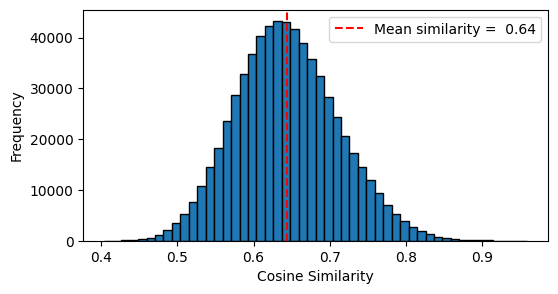

Max: 0.96


In [29]:
import matplotlib.pyplot as plt
import torch
similarity_to_plot = nomic_similarities

# Plot similarity distribution
plt.figure(figsize=(6, 3))
plt.hist(similarity_to_plot[similarity_to_plot < 0.99].flatten(), bins=50, edgecolor='black')
#plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
mean_sim = similarity_to_plot[similarity_to_plot < 0.99].mean()
plt.axvline(x=mean_sim, color='r',
            linestyle='--', label=f'Mean similarity = {mean_sim: 0.2f}')
plt.legend()
plt.show()
print(f"Max: {torch.max(similarity_to_plot[similarity_to_plot < 0.99]):.2f}")

If you want to remove the impact of the presentation that was in a session by itself, run the line below to remove it from the dataframe and any following results.

In [30]:
idx_to_remove = df_presentations[df_presentations['Abstract ID'] == 2401361].index
# Remove the row from df_presentations
df_presentations_no_single = df_presentations.drop(idx_to_remove)

# Remove the row and column from df_similarity
df_similarity_no_single = df_similarity.drop(index=idx_to_remove, columns=idx_to_remove) 

### Plot Presentation-Session Similarity

bins: 35


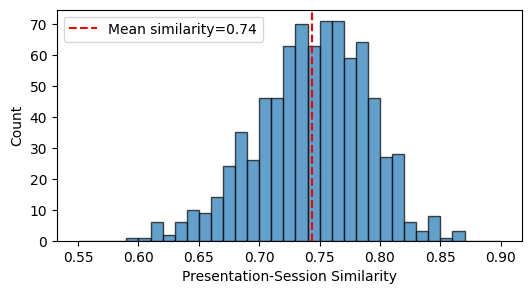

In [31]:
import matplotlib.pyplot as plt
import numpy as np
# Printing Uniform Histogram Charts
min_hist = 0.55
max_hist = 0.90
bin_width = 0.01
bin_num = int((max_hist-min_hist)/bin_width)
print(f"bins: {bin_num}")
# Plot similarity distributions
plt.figure(figsize=(6, 3))
pres_sess_sim = df_presentations_no_single['Presentation-Session Similarity']
plt.hist(pres_sess_sim, bins=bin_num, range=(min_hist, max_hist), alpha=0.7,
            #color='blue', 
            edgecolor='black')
plt.axvline(x=np.mean(pres_sess_sim), color='r',
            linestyle='--', label=f'Mean similarity={np.mean(pres_sess_sim):.2f}')
plt.xlabel('Presentation-Session Similarity')
plt.ylabel('Count')
#plt.title('Presentation-Session Similarity\n(Original Conference Oral Sessions)')
plt.legend()

plt.show()

### Plot Session Similarity

bins: 35


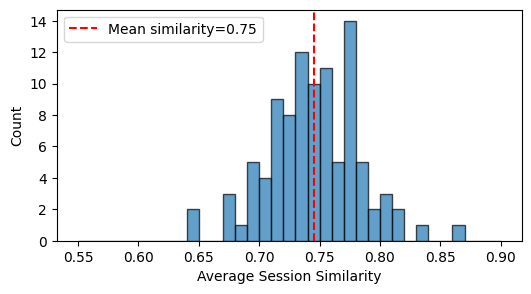

In [32]:
import matplotlib.pyplot as plt
import numpy as np
# Printing Uniform Histogram Charts
min_hist = 0.55
max_hist = 0.90
bin_width = 0.01
bin_num = int((max_hist-min_hist)/bin_width)
print(f"bins: {bin_num}")
orig_sessions = dict(zip(df_presentations_no_single['Original Session'], df_presentations_no_single['Session Similarity']))
orig_sessions_val = list(orig_sessions.values())
# Plot similarity distributions
plt.figure(figsize=(6, 3))
plt.hist(orig_sessions_val, bins=bin_num, range=(min_hist, max_hist), alpha=0.7,
            #color='blue', 
            edgecolor='black')
plt.axvline(x=np.mean(orig_sessions_val), color='r',
            linestyle='--', label=f'Mean similarity={np.mean(orig_sessions_val):.2f}')
plt.xlabel('Average Session Similarity')
plt.ylabel('Count')
#plt.title('Session Similarity\n(Original Conference Oral Sessions)')
plt.legend()

plt.show()

### View Sorted Tables of Sessions

In [33]:
df_sorted = df_sessions.sort_values(by='Session Similarity', ascending=False)
print("Most Similar Sessions")
print(df_sorted.head())
print("Least Similar Sessions")
print(df_sorted.tail(6))

Most Similar Sessions
                                     Original Session  Session Similarity  \
55  330 Monitoring Standards: Applications, Method...            0.860937   
89  235 Recent Developments in Crop Protection Pro...            0.838184   
0   242 Understanding the Agro-Hydrologic Effects ...            0.814872   
34   213 Machinery Systems Data and Task Optimization            0.811075   
71  332 Measurement, Mitigation and Modeling of Ai...            0.802929   

    Session Std Dev  
55         0.000000  
89         0.020569  
0          0.026573  
34         0.038518  
71         0.013588  
Least Similar Sessions
                                     Original Session  Session Similarity  \
95  206 Digital Twins, DEM, and CFD Applications i...            0.676997   
57  118 Agri-Industrial Facility Design and Operation            0.675718   
29  122 Physical and Chemical Properties of Food, ...            0.673748   
30                       318 Food Process Engineerin

Show the results for the session with more than 2 presentations and the highest similarity.
Checking for 2 presentations by ensuring session standard deviation is greater than 0.

In [34]:
df_sorted = df_sessions[df_sessions['Session Std Dev']>0].sort_values(by='Session Similarity', ascending=False)
session_to_plot = df_sorted.iloc[0]
print(session_to_plot)

Original Session      235 Recent Developments in Crop Protection Pro...
Session Similarity                                             0.838184
Session Std Dev                                                0.020569
Name: 89, dtype: object


In [35]:

print(f"Session: {session_to_plot['Original Session']}")
print(f"Session Similarity: {session_to_plot['Session Similarity']}")
#print(f"Session Similarity{df_sessions[]}")
df_presentations_no_single[df_presentations_no_single['Original Session']==session_to_plot['Original Session']][['Title', 'Presentation-Session Similarity']]

Session: 235 Recent Developments in Crop Protection Product and Fertilizer Unmanned Applications
Session Similarity: 0.8381844758987427


,Title,Presentation-Session Similarity
327,UAS Sprayer Pattern Evaluation Under Different...,0.847507
457,Determination of canopy characteristics of orn...,0.814024
467,Spray Deposition and In-Swath Uniformity of Un...,0.862583
501,Rate and Uniformity Assessment of Dry Material...,0.843520
505,An update on developing a prototype of intelli...,0.831831
535,Performance Evaluation of a Solar Energy Opera...,0.803649
635,Assessment of Spray Patterns and Efficiency of...,0.858123
1122,Design and Development of spraying system for ...,0.844238


The lowest session. The very lowest ranked session has a score of 0 since it had only one presentation, but that does not have a standard deviation.

In [36]:
df_sorted = df_sessions[df_sessions['Session Std Dev']>0].sort_values(by='Session Similarity', ascending=False)
session_to_plot = df_sorted.iloc[-1]
print(session_to_plot)

Original Session      228 Analytical, Computational and Instrumentat...
Session Similarity                                             0.640503
Session Std Dev                                                0.025341
Name: 52, dtype: object


In [37]:
print(f"Session: {session_to_plot['Original Session']}")
print(f"Session Similarity: {session_to_plot['Session Similarity']}")
#print(f"Session Similarity{df_sessions[]}")
df_presentations_no_single[df_presentations_no_single['Original Session']==session_to_plot['Original Session']][['Title', 'Presentation-Session Similarity']].sort_values(by='Presentation-Session Similarity', ascending=False)

Session: 228 Analytical, Computational and Instrumentation Advances for Biosensing
Session Similarity: 0.6405032873153687


,Title,Presentation-Session Similarity
690,A novel nitrogen oxide sensor for measurement ...,0.677785
103,Non-destructive Detection Method for Lamb Meat...,0.659259
794,High-Throughput Measurement of Maize Flexural ...,0.654711
1039,Enhancing SIF-based Prediction of Gross Primar...,0.648174
1051,Characteristics of Chlorophyll Fluorescence in...,0.642094
1160,Comparative analysis of localized vs. mesoscal...,0.623872
1014,Cellphone for bees,0.619953
1138,A simple microfluidic biosensor based on membr...,0.598179


#### Session with Greatest Standardized Deviation


In [38]:
df_sorted = df_presentations_no_single.sort_values(by='Standardized Deviation', ascending=True)
pres_session_to_plot = df_sorted.iloc[0]
print(f"Session: {pres_session_to_plot['Original Session']}")
print(f"Session Similarity: {pres_session_to_plot['Session Similarity']}")
print(f"Session Std Dev: {pres_session_to_plot['Session Std Dev']}")
session_to_plot = df_presentations_no_single[df_presentations_no_single['Original Session']==pres_session_to_plot['Original Session']][['Title', 'Presentation-Session Similarity', 'Standardized Deviation']]
session_to_plot.sort_values(by='Standardized Deviation', ascending=True)

Session: 230 Machine Vision for Precision Agriculture and Robotics-LIGHTNING TALKS
Session Similarity: 0.7304843664169312
Session Std Dev: 0.032856126199055924


,Title,Presentation-Session Similarity,Standardized Deviation
542,The effect of different toys on the behavior a...,0.618908,-3.395901
443,Obstacle Perception for Korean Autonomous Trac...,0.704983,-0.776165
216,Evaluation of a machine-vision based estrus de...,0.709660,-0.633812
920,Unified Deep Learning Models for Strawberry Ma...,0.727895,-0.078803
1141,Multimodal Machine Learning for Comprehensive ...,0.735531,0.153595
1086,Enhancing Seeding Efficiency: Evaluating Row C...,0.736278,0.176322
1158,Quantized deep learning object detection model...,0.739138,0.263391
963,Using Boll Images and Numerical Data to Predic...,0.739209,0.265530
950,Semi-Supervised Panoptic Segmentation for Appl...,0.739447,0.272782
355,"Automated Identification of Tomato Pests, Dise...",0.739926,0.287377


The above session is in a lightning round with many other presentations. Plotting the next worst outlier.

In [39]:
df_sorted = df_presentations_no_single.sort_values(by='Standardized Deviation', ascending=True)
pres_session_to_plot = df_sorted.iloc[1]
print(f"Session: {pres_session_to_plot['Original Session']}")
print(f"Session Similarity: {pres_session_to_plot['Session Similarity']}")
print(f"Session Std Dev: {pres_session_to_plot['Session Std Dev']}")
session_to_plot = df_presentations_no_single[df_presentations_no_single['Original Session']==pres_session_to_plot['Original Session']][['Title', 'Presentation-Session Similarity', 'Standardized Deviation']]
session_to_plot.sort_values(by='Standardized Deviation', ascending=True)

Session: 115 Innovations in Crop Protection Product and Application Equipment Development
Session Similarity: 0.7224329710006714
Session Std Dev: 0.04198074339815315


,Title,Presentation-Session Similarity,Standardized Deviation
494,Microwave Treatment Techniques for Managing We...,0.614390,-2.573636
335,Surface engineering of biobased microcarriers ...,0.702125,-0.483742
210,Turn Performance Analysis for a Self Propelled...,0.718776,-0.087111
393,Performance of hollow-cone nozzles coupled wit...,0.720646,-0.042560
750,Developing Next Generation Functional Anti-Dri...,0.729424,0.166528
60,Sensitivity Analysis of a Hydraulic Lift Arm S...,0.732880,0.248860
781,UPDATES AND CONTINUED DEVELOPMENT OF A HIGH RE...,0.743927,0.512003
392,Determining Spray Volume Rates for Apple Trees...,0.744516,0.526019
710,Selection of least-drifting spray nozzles for ...,0.757580,0.837217
28,Utilization of High Resolution Patternator Dat...,0.760065,0.896412


### Finding another home for a presentation
In this session, one presentation "Microwave Treatment Techniques..." stands out as having a much larger standardized deviation. Perhaps there is a better home for this presentation in another session?
Sort the list of presentations to find other similar presentations.

In [40]:
print("Most Similar Presentations")
similar_presentations = df_similarity_no_single.loc[pres_session_to_plot.name].sort_values(ascending=False) # Create a Series with the  most similar presentations
# Remove the selected presentation itself from the similar presentations
similar_presentations = similar_presentations.drop(pres_session_to_plot.name)
# Build the similarity dataframe. Add the similarity score and similarity rank to the dataframe and show it.
similar_df = df_presentations_no_single.loc[similar_presentations.index]
similar_df.insert(0, "Similarity Score", similar_presentations)
similar_df.insert(0, "Similarity Rank", np.arange(1,similar_df.shape[0]+1))
print(similar_df[['Title', 'Presentation-Session Similarity']].head())

Most Similar Presentations
                                                  Title  \
493   Exploring the potential of microwave heating f...   
385   Optimizing Radiofrequency Exposure Parameters ...   
1008  Development and Evaluation of Directed Energy ...   
212   Design and Evaluation of a Novel Band-Steam Ap...   
449   DEVELOPMENT OF A REMOTELY CONTROLLED  SELF-PRO...   

      Presentation-Session Similarity  
493                          0.727243  
385                          0.733761  
1008                         0.718623  
212                          0.678509  
449                          0.783238  


# Comparing Embedding Models
These steps show the methods used to compare the models.

### Calculate time with embedding truncated to 256 tokens.
Truncation Function:

In [41]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer

def truncate_texts(texts, max_length, model_name):
    """
    Truncates a list of text strings to a maximum number of tokens using the 
    tokenizer associated with a SentenceTransformer model.

    Args:
      texts: A list of input text strings.
      max_length: The maximum number of tokens allowed.
      model_name: The name of the SentenceTransformer model.

    Returns:
      A list of truncated text strings.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    truncated_texts = []
    for text in texts:
        tokens = tokenizer.tokenize(text)
        truncated_tokens = tokens[:max_length]
        truncated_text = tokenizer.convert_tokens_to_string(truncated_tokens)
        truncated_texts.append(truncated_text)
    return truncated_texts

#### Create truncated inputs texts

In [42]:
max_tokens = 256

mini_embeddings_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', trust_remote_code=True) 
mini_truncated_text = truncate_texts(oral_topics, max_tokens, 'sentence-transformers/all-MiniLM-L6-v2')

Token indices sequence length is longer than the specified maximum sequence length for this model (730 > 512). Running this sequence through the model will result in indexing errors


#### First Confirm Truncation and Tokenizers are the same between models

Tokenziers produce the same result:

In [43]:
model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True) 
nomic_truncated_text = truncate_texts(oral_topics, max_tokens, "nomic-ai/nomic-embed-text-v1.5")
# Are they the same?
print(f"Tokenziers produce the same result:{mini_truncated_text == nomic_truncated_text}")

<All keys matched successfully>


Tokenziers produce the same result:True


Since the maximum token length of all-MiniLM-L6-v2 was 256, truncating the input strings to 256 tokens should not result in any change to the embeddings.

In [44]:
import time
import numpy as np
start_time = time.time()
mini_truncated_embeddings = mini_embeddings_model.encode(mini_truncated_text)
end_time = time.time()
mini_trunc_elapsed_time = end_time - start_time
print(f"Encoding time: {mini_trunc_elapsed_time:.4f} seconds")
#Compare
print(f"Truncated embeddings the same? {np.array_equal(mini_embeddings, mini_truncated_embeddings)}")
mini_truncated_similarities = mini_embeddings_model.similarity(mini_truncated_embeddings, mini_truncated_embeddings)

Encoding time: 19.7935 seconds
Truncated embeddings the same? True


### Embed truncated texts

In [45]:
# Calculate mpnet embeddings
mpnet_embeddings_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', trust_remote_code=True) 
start_time = time.time()
mpnet_truncated_embeddings = mpnet_embeddings_model.encode(mini_truncated_text)
end_time = time.time()
mpnet_trunc_elapsed_time = end_time - start_time
print(f"Titles Embedded: {len(mpnet_truncated_embeddings)}, Length of Vectors: {len(mpnet_truncated_embeddings[0])}")
print(f"Encoding time: {mpnet_trunc_elapsed_time:.4f} seconds")
mpnet_truncated_similarities = mpnet_embeddings_model.similarity(mpnet_truncated_embeddings, mpnet_truncated_embeddings)

Titles Embedded: 810, Length of Vectors: 768
Encoding time: 154.6471 seconds


In [46]:
# Calculate cde embeddings
# Line below should be uncommented to run. It must be commented out for Git commit as its output is interpreted as containing a secret. 
# cde_embeddings_model = SentenceTransformer('jxm/cde-small-v1', trust_remote_code=True)
import random
minicorpus_size = cde_embeddings_model[0].config.transductive_corpus_size
minicorpus_docs = random.sample(mini_truncated_text, k=minicorpus_size) # Put some strings here that are representative of your corpus, for example by calling random.sample(corpus, k=minicorpus_size)
assert len(minicorpus_docs) == minicorpus_size # You must use exactly this many documents in the minicorpus. You can oversample if your corpus is smaller.
start_time = time.time()
dataset_embeddings = cde_embeddings_model.encode(
    minicorpus_docs,
    prompt_name="document",
    convert_to_tensor=True
)
end_time = time.time()
cde_dataset_trunc_elapsed_time = end_time - start_time
print(f"Dataset Encoding time: {cde_dataset_trunc_elapsed_time:.4f} seconds")

start_time = time.time()
cde_truncated_embeddings = cde_embeddings_model.encode(
    mini_truncated_text,
    prompt_name="document",
    dataset_embeddings=dataset_embeddings,
    convert_to_tensor=True,
)
end_time = time.time()

cde_doc_trunc_elapsed_time = end_time - start_time
print(f"Titles Embedded: {len(cde_truncated_embeddings)}, Length of Vectors: {len(cde_truncated_embeddings[0])}")
print(f"Document Encoding time: {cde_doc_trunc_elapsed_time:.4f} seconds")
cde_trunc_elapsed_time = cde_doc_trunc_elapsed_time+cde_dataset_trunc_elapsed_time
print(f"Total Encoding time: {(cde_doc_trunc_elapsed_time+cde_dataset_trunc_elapsed_time):.4f} seconds")
cde_truncated_similarities = cde_embeddings_model.similarity(cde_truncated_embeddings, cde_truncated_embeddings)

C:\Users\jdv223\.cache\huggingface\modules\transformers_modules\nomic-ai\nomic-bert-2048\40b98394640e630d5276807046089b233113aa87\modeling_hf_nomic_bert.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relate

Disabled 37 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.    .model.BiEncoder'>
modified 12 rotary modules – set rotary_start_pos to 512
Disabled 74 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.    .model.DatasetTransformer'>
Dataset Encoding time: 112.3868 seconds
Titles Embedded: 810, Length of Vectors: 768
Document Encoding time: 566.9941 seconds
Total Encoding time: 679.3810 seconds


In [47]:
# Embed the documents
import time
from nomic import embed
start_time = time.time()
output = embed.text(
    texts=mini_truncated_text,
    model='nomic-embed-text-v1.5',
    task_type='clustering',
    inference_mode='local',
)

mode = output['inference_mode']  # 'local'
print(mode)
nomic_truncated_embeddings = output['embeddings']
end_time = time.time()
nomic_trunc_elapsed_time = end_time - start_time
print(f"Titles Embedded: {len(nomic_truncated_embeddings)}, Length of Vectors: {len(nomic_truncated_embeddings[0])}")
print(f"Encoding time: {nomic_trunc_elapsed_time:.4f} seconds")

nomic_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)
nomic_truncated_similarities = nomic_model.similarity(nomic_truncated_embeddings, nomic_truncated_embeddings)


local
Titles Embedded: 810, Length of Vectors: 768
Encoding time: 829.2449 seconds


<All keys matched successfully>


### Save the truncated embeddings

In [48]:
import torch
import pickle
# Save the embeddings to files
with open('oral mini truncated_embeddings.pkl', 'wb') as file:
    pickle.dump(mini_truncated_embeddings, file)
with open('oral mpnet truncated_embeddings.pkl', 'wb') as file:
    pickle.dump(mpnet_truncated_embeddings, file)
with open('oral cde truncated_embeddings.pkl', 'wb') as file:
    pickle.dump(cde_truncated_embeddings, file)
with open('oral nomic truncated_embeddings.pkl', 'wb') as file:
    pickle.dump(nomic_truncated_embeddings, file)
# Save the truncated similarities
torch.save(mini_truncated_similarities, 'oral mini truncated similarities.pt')
torch.save(mpnet_truncated_similarities, 'oral mpnet truncated similarities.pt')
torch.save(cde_truncated_similarities, 'oral cde truncated similarities.pt')
torch.save(nomic_truncated_similarities, 'oral nomic truncated similarities.pt')

## Load Truncated Embeddings and Similarities
Load the Truncated Embeddings

In [ ]:

import torch
import pickle
import numpy as np
import pandas as pd

# Load the embeddings from files
with open('oral mini truncated_embeddings.pkl', 'rb') as file:
    mini_truncated_embeddings = pickle.load(file)
with open('oral mpnet truncated_embeddings.pkl', 'rb') as file:
    mpnet_truncated_embeddings = pickle.load(file)
with open('oral cde truncated_embeddings.pkl', 'rb') as file:
    cde_truncated_embeddings = pickle.load(file)
with open('oral nomic truncated_embeddings.pkl', 'rb') as file:
    nomic_truncated_embeddings = pickle.load(file)


##### Load the Truncated Similarity Tensors

In [ ]:
mini_truncated_similarities = torch.load('oral mini truncated similarities.pt', weights_only=False)
mpnet_truncated_similarities = torch.load('oral mpnet truncated similarities.pt', weights_only=False)
cde_truncated_similarities = torch.load('oral cde truncated similarities.pt', weights_only=False)
nomic_truncated_similarities = torch.load('oral nomic truncated similarities.pt', weights_only=False)

#### Save the Embedding Model Results

In [49]:
mini_tokenizer = mini_embeddings_model.tokenizer
mini_max_length = mini_tokenizer.model_max_length
mpnet_tokenizer = mpnet_embeddings_model.tokenizer
mpnet_max_length = mpnet_tokenizer.model_max_length
cde_tokenizer = cde_embeddings_model.tokenizer
cde_max_length = cde_tokenizer.model_max_length
nomic_embeddings_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)
nomic_tokenizer = nomic_embeddings_model.tokenizer
nomic_max_length = nomic_tokenizer.model_max_length

mini_dict = {'token_length': mini_max_length, 
             'name': mini_embeddings_model.model_card_data.base_model,
             'time':mini_elapsed_time,
             'truncated time':mini_trunc_elapsed_time}
mpnet_dict = {'token_length': mpnet_max_length, 
              'name': mpnet_embeddings_model.model_card_data.base_model,
              'time':mpnet_elapsed_time,
              'truncated time':mpnet_trunc_elapsed_time}
cde_dict = {'token_length': cde_max_length, 
            'name': cde_embeddings_model.model_card_data.base_model,
            'time':cde_elapsed_time, 
            'dataset time ': cde_dataset_elapsed_time, 
            'doc time ': cde_doc_elapsed_time,
            'truncated time':cde_trunc_elapsed_time,
            'truncated dataset time':cde_dataset_trunc_elapsed_time,
            'truncated doc time':cde_doc_trunc_elapsed_time}
nomic_dict = {'token_length': nomic_max_length, 
              'name': nomic_embeddings_model.model_card_data.base_model,
              'time':nomic_elapsed_time,
              'truncated time':nomic_trunc_elapsed_time}

models_list = [mini_dict, mpnet_dict, cde_dict, nomic_dict]

import pickle
# Save the result to file
with open('models list.pkl', 'wb') as file:
    pickle.dump(models_list, file)

<All keys matched successfully>


## Similarity Correlation

Similarities with the full inputs:

In [50]:
import pandas as pd

# Create a dictionary where keys are column names and values are flattened arrays
data = {
    'nomic-embed-text-v1.5': nomic_similarities.flatten(),
    'cde-small-v1': cde_similarities.flatten(),
    'all-mpnet-base-v2': mpnet_similarities.flatten(),
    'all-MiniLM-L6-v2': mini_similarities.flatten(),
}

# Create the DataFrame directly from the dictionary
flat_sim = pd.DataFrame(data)
correlation_matrix_full = flat_sim.corr()
print(correlation_matrix_full)



                       nomic-embed-text-v1.5  cde-small-v1  all-mpnet-base-v2  \
nomic-embed-text-v1.5               1.000000      0.850277           0.866077   
cde-small-v1                        0.850277      1.000000           0.837792   
all-mpnet-base-v2                   0.866077      0.837792           1.000000   
all-MiniLM-L6-v2                    0.826049      0.792794           0.878327   

                       all-MiniLM-L6-v2  
nomic-embed-text-v1.5          0.826049  
cde-small-v1                   0.792794  
all-mpnet-base-v2              0.878327  
all-MiniLM-L6-v2               1.000000  


Similarities with input tokens truncated to 256:

In [51]:
import pandas as pd

# Create a dictionary where keys are column names and values are flattened arrays
data = {
    'nomic-embed-text-v1.5 truncated': nomic_truncated_similarities.flatten(),
    'cde-small-v1 truncated': cde_truncated_similarities.flatten(),
    'all-mpnet-base-v2 truncated': mpnet_truncated_similarities.flatten(),
    'all-MiniLM-L6-v2 truncated': mini_truncated_similarities.flatten(),
}

# Create the DataFrame directly from the dictionary
flat_sim_trun = pd.DataFrame(data)
correlation_matrix_truncated = flat_sim_trun.corr()
print(correlation_matrix_truncated)

                                 nomic-embed-text-v1.5 truncated  \
nomic-embed-text-v1.5 truncated                         1.000000   
cde-small-v1 truncated                                  0.836752   
all-mpnet-base-v2 truncated                             0.862697   
all-MiniLM-L6-v2 truncated                              0.830376   

                                 cde-small-v1 truncated  \
nomic-embed-text-v1.5 truncated                0.836752   
cde-small-v1 truncated                         1.000000   
all-mpnet-base-v2 truncated                    0.826952   
all-MiniLM-L6-v2 truncated                     0.792837   

                                 all-mpnet-base-v2 truncated  \
nomic-embed-text-v1.5 truncated                     0.862697   
cde-small-v1 truncated                              0.826952   
all-mpnet-base-v2 truncated                         1.000000   
all-MiniLM-L6-v2 truncated                          0.887056   

                                 all-MiniL

Comparing all Similarities (Full and Truncated)

In [52]:
import pandas as pd

# Create a dictionary where keys are column names and values are flattened arrays
data = {
    'nomic-embed-text-v1.5': nomic_similarities.flatten(),
    'nomic-embed-text-v1.5 truncated': nomic_truncated_similarities.flatten(),
    'cde-small-v1': cde_similarities.flatten(),
    'cde-small-v1 truncated': cde_truncated_similarities.flatten(),
    'all-mpnet-base-v2': mpnet_similarities.flatten(),
    'all-mpnet-base-v2 truncated': mpnet_truncated_similarities.flatten(),
    'all-MiniLM-L6-v2': mini_similarities.flatten(),
    'all-MiniLM-L6-v2 truncated': mini_truncated_similarities.flatten(),
}

# Create the DataFrame directly from the dictionary
flat_all_sim = pd.DataFrame(data)
correlation_matrix_all = flat_all_sim.corr()
print(correlation_matrix_all)

                                 nomic-embed-text-v1.5  \
nomic-embed-text-v1.5                         1.000000   
nomic-embed-text-v1.5 truncated               0.981271   
cde-small-v1                                  0.850277   
cde-small-v1 truncated                        0.832908   
all-mpnet-base-v2                             0.866077   
all-mpnet-base-v2 truncated                   0.861018   
all-MiniLM-L6-v2                              0.826049   
all-MiniLM-L6-v2 truncated                    0.826049   

                                 nomic-embed-text-v1.5 truncated  \
nomic-embed-text-v1.5                                   0.981271   
nomic-embed-text-v1.5 truncated                         1.000000   
cde-small-v1                                            0.834649   
cde-small-v1 truncated                                  0.836752   
all-mpnet-base-v2                                       0.853862   
all-mpnet-base-v2 truncated                             0.862697   
a

## Session Similarity Lists by Embedding Model
Display the 5 most similar and the 5 least similar sessions by embedding model.
First, a function sort the sessions.

In [53]:
import numpy as np

def sessions_by_similarity(df_similarity, df_presentations):
    """
    Calculates session similarity metrics and sorts sessions by their overall similarity.

    Args:
        df_similarity: DataFrame containing the pairwise similarity between presentations.
        df_presentations: DataFrame with presentation information, including 'Original Session' column.

    Returns:
        DataFrame: Sorted DataFrame with session information and similarity metrics.
    """
    
    pres_session_similarity, session_similarity = calculate_cluster_similarities(
        df_similarity.to_numpy(), np.array(df_presentations['Original Session'])
    )
    df_presentations['Presentation-Session Similarity'] = pres_session_similarity
    df_presentations['Session Similarity'] = df_presentations['Original Session'].map(session_similarity)

    # Calculate standard deviation for each 'Original Session'
    df_presentations['Session Std Dev'] = df_presentations.groupby('Original Session')['Presentation-Session Similarity'].transform('std')
    # Calculate deviation from the mean
    df_presentations['Raw Deviation'] = df_presentations['Presentation-Session Similarity'] - df_presentations['Session Similarity']
    # Calculate standardized deviation
    df_presentations['Standardized Deviation'] = df_presentations['Raw Deviation'] / df_presentations['Session Std Dev']

    # Create the Sessions DataFrame
    df_sessions = df_presentations[['Original Session', 'Session Similarity', 'Session Std Dev']].copy()
    # Drop duplicate rows, keeping only the first instance, then reindex.
    df_sessions.drop_duplicates(subset=['Original Session'], keep='first', inplace=True)
    df_sessions = df_sessions.reset_index(drop=True)

    df_sorted = df_sessions.sort_values(by='Session Similarity', ascending=False)
    return df_sorted

### all-MiniLM-L6-v2 

In [54]:
df_sorted_mini = sessions_by_similarity(df_similarity_mini, df_presentations)
print("Most Similar Sessions")
print(df_sorted_mini.head())
print("Least Similar Sessions")
print(df_sorted_mini.tail(6))

Most Similar Sessions
                                     Original Session  Session Similarity  \
55  330 Monitoring Standards: Applications, Method...            0.603709   
3   215 Applications of Remote Sensing and UAVs in...            0.575766   
0   242 Understanding the Agro-Hydrologic Effects ...            0.539714   
46  329 Manure Anaerobic Digestion Systems and Biogas            0.535649   
34   213 Machinery Systems Data and Task Optimization            0.530231   

    Session Std Dev  
55         0.000000  
3          0.054709  
0          0.057813  
46         0.054782  
34         0.072914  
Least Similar Sessions
                                     Original Session  Session Similarity  \
35  109 Agricultural Automation, Robotics, and Tec...            0.291099   
30                       318 Food Process Engineering            0.272050   
29  122 Physical and Chemical Properties of Food, ...            0.262596   
31                        334 Food Safety Engineerin

### all-mpnet-base-v2

In [55]:
df_sorted_mpnet = sessions_by_similarity(df_similarity_mpnet, df_presentations)
print("Most Similar Sessions")
print(df_sorted_mpnet.head())
print("Least Similar Sessions")
print(df_sorted_mpnet.tail(6))

Most Similar Sessions
                                     Original Session  Session Similarity  \
0   242 Understanding the Agro-Hydrologic Effects ...            0.673211   
89  235 Recent Developments in Crop Protection Pro...            0.671140   
34   213 Machinery Systems Data and Task Optimization            0.633848   
3   215 Applications of Remote Sensing and UAVs in...            0.623618   
55  330 Monitoring Standards: Applications, Method...            0.621249   

    Session Std Dev  
0          0.051228  
89         0.056951  
34         0.070188  
3          0.051875  
55         0.000000  
Least Similar Sessions
                                     Original Session  Session Similarity  \
72  326 Advances in Agrohydrological Sustainabilit...            0.339471   
95  206 Digital Twins, DEM, and CFD Applications i...            0.339134   
29  122 Physical and Chemical Properties of Food, ...            0.332687   
30                       318 Food Process Engineerin

### cde-small-v1

In [56]:
df_sorted_cde = sessions_by_similarity(df_similarity_cde, df_presentations)
print("Most Similar Sessions")
print(df_sorted_cde.head())
print("Least Similar Sessions")
print(df_sorted_cde.tail(6))

Most Similar Sessions
                                     Original Session  Session Similarity  \
55  330 Monitoring Standards: Applications, Method...            0.736611   
89  235 Recent Developments in Crop Protection Pro...            0.724212   
0   242 Understanding the Agro-Hydrologic Effects ...            0.713328   
82  125 Exploring Safety in the Era of Autonomous ...            0.708768   
16  129 AI-Driven Tools and Technologies for High ...            0.694384   

    Session Std Dev  
55         0.000000  
89         0.038676  
0          0.039953  
82         0.033295  
16         0.030068  
Least Similar Sessions
                                     Original Session  Session Similarity  \
29  122 Physical and Chemical Properties of Food, ...            0.503785   
57  118 Agri-Industrial Facility Design and Operation            0.500282   
52  228 Analytical, Computational and Instrumentat...            0.499576   
31                        334 Food Safety Engineerin

### nomic-embed-text-v1.5

In [57]:
df_sorted_nomic = sessions_by_similarity(df_similarity_nomic, df_presentations)
print("Most Similar Sessions")
print(df_sorted_nomic.head())
print("Least Similar Sessions")
print(df_sorted_nomic.tail(6))

Most Similar Sessions
                                     Original Session  Session Similarity  \
55  330 Monitoring Standards: Applications, Method...            0.860937   
89  235 Recent Developments in Crop Protection Pro...            0.838184   
0   242 Understanding the Agro-Hydrologic Effects ...            0.814872   
34   213 Machinery Systems Data and Task Optimization            0.811075   
71  332 Measurement, Mitigation and Modeling of Ai...            0.802929   

    Session Std Dev  
55         0.000000  
89         0.020569  
0          0.026573  
34         0.038518  
71         0.013588  
Least Similar Sessions
                                     Original Session  Session Similarity  \
95  206 Digital Twins, DEM, and CFD Applications i...            0.676997   
57  118 Agri-Industrial Facility Design and Operation            0.675718   
29  122 Physical and Chemical Properties of Food, ...            0.673748   
30                       318 Food Process Engineerin

In [58]:
# Save the sorted list dataframes
df_sorted_mini.to_pickle('miniLM_sorted lists.pkl')
df_sorted_mpnet.to_pickle('mpnet_sorted lists.pkl') 
df_sorted_cde.to_pickle('cde_sorted lists.pkl')
df_sorted_nomic.to_pickle('nomic_sorted lists.pkl')